# LIBS

In [74]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import csv
import matplotlib.pyplot as plt

# Data

Parameters

In [75]:
DATA_PATH = os.path.join('model/data')
SEQUENCE_LENGTH = 25 # 25 frames per sequence    

Load Data

In [76]:
with open("model/custom_model_label.csv", encoding='utf-8-sig') as f:
            label_map = csv.reader(f)
            label_map = {
                row[0]: index for index, row in enumerate(label_map)
            }
            actions = list(label_map.keys())

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(X[1].shape)  # ti stampa la shape del primo esempio (dovrebbe essere (25, 126))


[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
X_train: (42, 25, 258), y_train: (42, 3)
X_test: (3, 25, 258), y_test: (3, 3)
(25, 258)


Logs

In [77]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# MODEL

Def Model

In [78]:
model = Sequential()
model.add(Input(shape=(X.shape[1:])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

Compile Model

In [79]:
optimizer = Adam(learning_rate=0.0001)
early_stop = EarlyStopping(
    monitor='val_loss',        # o 'val_categorical_accuracy'
    patience=5,                # numero di epoche senza miglioramento prima di fermarsi
    restore_best_weights=True # ripristina i pesi migliori
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Fit Model (Only When Re-Run the Model)

In [80]:
history = model.fit(X_train, y_train, epochs=500, batch_size=6, validation_split=0.2, callbacks=[early_stop])

Epoch 1/500
6/6 [==============================] - 5s 228ms/step - loss: 1.0946 - categorical_accuracy: 0.4242 - val_loss: 1.1060 - val_categorical_accuracy: 0.1111
Epoch 2/500
6/6 [==============================] - 0s 35ms/step - loss: 1.0365 - categorical_accuracy: 0.4848 - val_loss: 1.0690 - val_categorical_accuracy: 0.4444
Epoch 3/500
6/6 [==============================] - 0s 39ms/step - loss: 0.9963 - categorical_accuracy: 0.5758 - val_loss: 1.0283 - val_categorical_accuracy: 0.6667
Epoch 4/500
6/6 [==============================] - 0s 25ms/step - loss: 0.9378 - categorical_accuracy: 0.6364 - val_loss: 0.9877 - val_categorical_accuracy: 0.6667
Epoch 5/500
6/6 [==============================] - 0s 35ms/step - loss: 0.8773 - categorical_accuracy: 0.7879 - val_loss: 0.9474 - val_categorical_accuracy: 0.8889
Epoch 6/500
6/6 [==============================] - 0s 36ms/step - loss: 0.8095 - categorical_accuracy: 0.8788 - val_loss: 0.8985 - val_categorical_accuracy: 1.0000
Epoch 7/500
6/6

Trainig graph

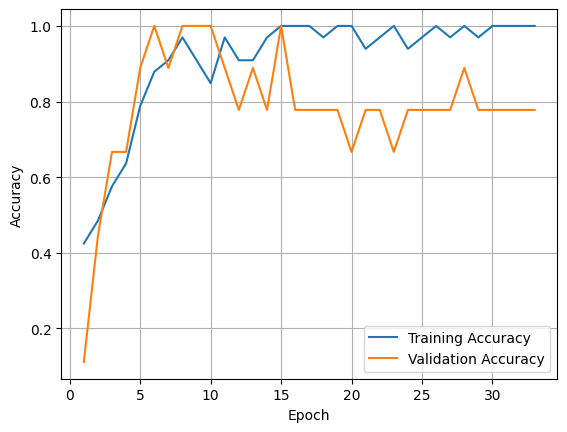

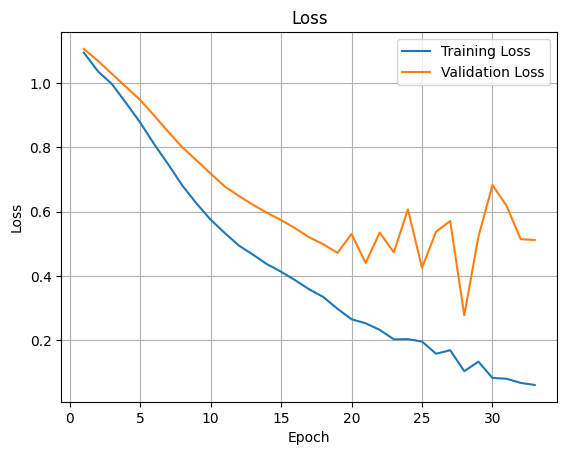

The best weights were obtained at the epoch 28 with val_loss = 0.2780


In [81]:
epochs = range(1, len(history.history['categorical_accuracy']) + 1)
plt.plot(epochs,history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs,history.history['loss'], label='Training Loss')
plt.plot(epochs,history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss')
plt.show()


val_losses = history.history['val_loss']
best_epoch = np.argmin(val_losses)
print(f"The best weights were obtained at the epoch {best_epoch + 1} with val_loss = {val_losses[best_epoch]:.4f}")

Load Model

In [82]:
# model = load_model('model/save_model.keras')

Save Model

In [83]:
model.save('model/save_model.keras')

Sumary Model

In [84]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 25, 64)            82688     
                                                                 
 lstm_13 (LSTM)              (None, 25, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 237,251
Trainable params: 237,251
Non-tr

# Evaluation

In [85]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

Test data

In [86]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1/1 [==============================] - 1s 992ms/step


Confusion Matrix

In [87]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 1]],

       [[1, 0],
        [1, 1]],

       [[2, 1],
        [0, 0]]], dtype=int64)

Accuracyt Score (1 is good, 0 bad)

In [88]:
accuracy_score(ytrue, yhat)

0.6666666666666666